# K-Means algorithm
Prepared by Karol Wesołowski (148116) and Stefan Zbąszyniak (148078)
Introduction to Machine Learning and Neural Networks
Poznan University of Technology, faculty of Computer Science and Telecommunication
Winter Semester 2023

## 1. Task
The goal of this exercise is to implement the K-means algorithm for clustering of data and to test it on 'cereal' dataset.
The algorithm is to be written in python, without using the already implemented method from scikit-learn library. The library can be used for preprocessing the data. The result is to be presented in a way, that will let the reader decide the importance of attributes for the outcome (affiliation to the cluster). 
The workflow is as follows:
1. Loading data
2. Preprocessing - mapping columns, dropping unnecessary and redundant attributes, normalisation
3. Clustering of data using k-means algorithm
4. Presentation of results.

## 2. Preparation
To implement the algorithm, the following libraries are necessary:
* pandas and NumPy for data analysis
* seaborn and MatPlotLib PyPlot for visualisation
* SciKit-learn for preprocessing the data
Additionally, the constants are defined on this step. `eps` defines the precision of computations. The default settings for plots are set. 

In [26]:
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [27]:
sns.set_style('darkgrid')
plt.rc('figure', figsize=(12, 8), dpi=200)
eps = 1e-5

## 3. Preprocessing
Data is read from file using pandas function `read_csv`. After that the preprocessing starts.
1. Columns `name` and `mfr` are unnecessary, and thus are removed from the set
2. Column `type` contains nominal values, that can be converted into binary. The value is mapped (C -> 1, H -> 0)
3. Using SciKit StandardScaler, data is normalised (every value is converted to one in the range from -1 to 1)
4. Pairs of attributes with high correlation (above given threshold) are selected. From the pairs, element with higher variance is kept, with lower - dropped.
5. The correlation is presented on a heatmap as well as an excerpt from the dataset.

In [28]:
def correlated_columns(data:pd.DataFrame, threshold:float):
    pairs = []
    for i, a in enumerate(data.columns): 
        for j, b in enumerate(data.columns):
            if i < j: # to limit operation, matrix is skew-symmetric there is no point in calculating upper triangle and main diagonal
                r = np.abs(np.corrcoef(data[a], data[b]))[0,1] # Pearson correlation, absolut value for ease of comparison
                if r > threshold:
                    pairs.append((a, b, r))
    return pairs

def drop_features(data:pd.DataFrame, threshold:float):
    for a, b, correlation in correlated_columns(data, threshold):
        if a in data.columns and b in data.columns: 
            if data[a].var() > data[b].var(): # element with higher variance is kept
                data.drop(b, axis=1, inplace=True)
            else:
                data.drop(a, axis=1, inplace=True)

   type  calories  protein  fat  sodium  fiber  carbo  sugars  potass  \
0     1        70        4    1     130   10.0    5.0       6     280   
1     1       120        3    5      15    2.0    8.0       8     135   
2     1        70        4    1     260    9.0    7.0       5     320   
3     1        50        4    0     140   14.0    8.0       0     330   
4     1       110        2    2     200    1.0   14.0       8      -1   

   vitamins  shelf  weight  cups     rating  
0        25      3     1.0  0.33  68.402973  
1         0      3     1.0  1.00  33.983679  
2        25      3     1.0  0.33  59.425505  
3        25      3     1.0  0.50  93.704912  
4        25      3     1.0  0.75  34.384843  


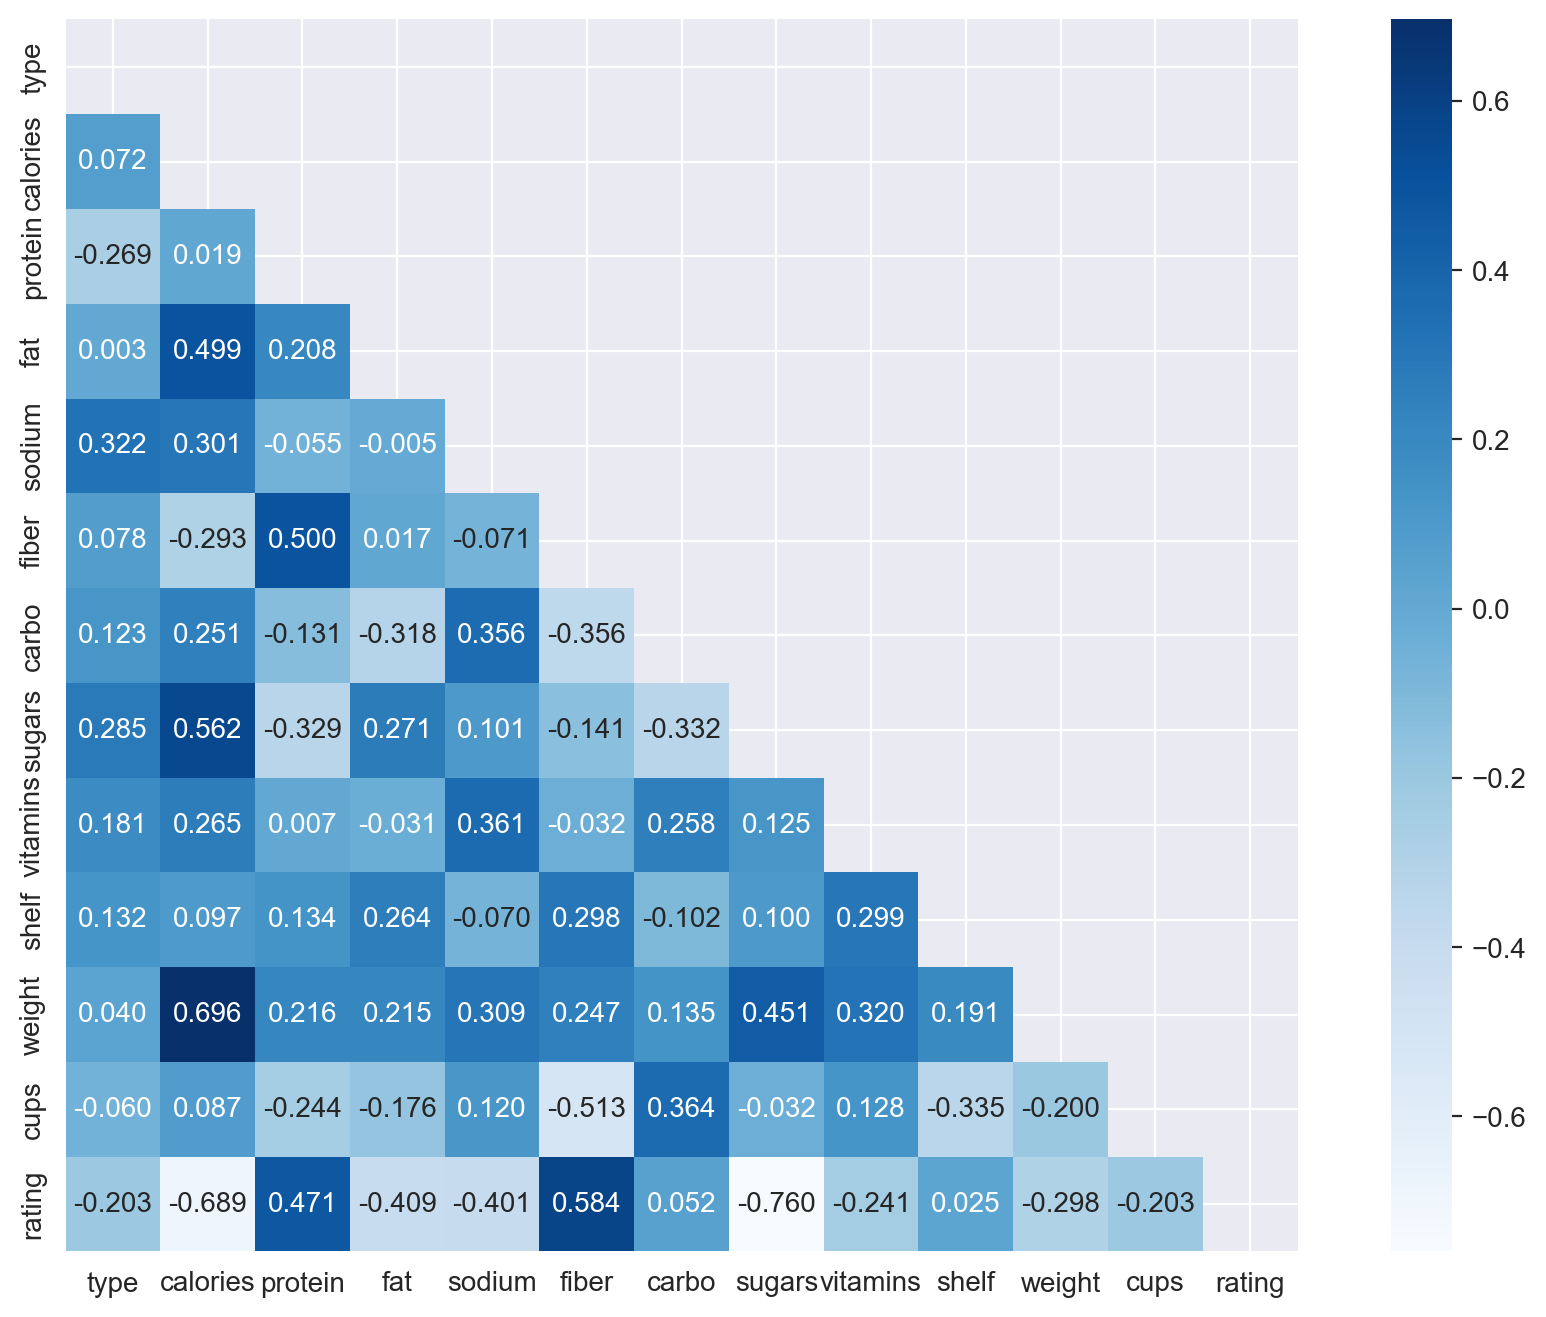

       type  calories   protein       fat    sodium     fiber     carbo  \
0  0.201347 -1.905397  1.337319 -0.012988 -0.356306  3.314439 -2.257639   
1  0.201347  0.677623  0.417912  3.987349 -1.737087 -0.064172 -1.551936   
2  0.201347 -1.905397  1.337319 -0.012988  1.204578  2.892113 -1.787170   
3  0.201347 -2.938605  1.337319 -1.013072 -0.236238  5.003745 -1.551936   
4  0.201347  0.161019 -0.501495  0.987096  0.484170 -0.486498 -0.140530   

     sugars  vitamins     shelf    weight      cups    rating  
0 -0.208807  -0.14627  0.957813 -0.198067 -2.123870  1.844202  
1  0.244099  -1.27255  0.957813 -0.198067  0.774053 -0.622110  
2 -0.435260  -0.14627  0.957813 -0.198067 -2.123870  1.200922  
3 -1.567525  -0.14627  0.957813 -0.198067 -1.388576  3.657211  
4  0.244099  -0.14627  0.957813 -0.198067 -0.307262 -0.593365  


In [29]:
data = pd.read_csv("data/cereal.csv")
data = data.drop(['name', 'mfr'], axis=1) # unnecessary columns
data['type'] = data['type'].apply(lambda typ: 1 if typ == 'C' else 0) # mapping nominal to binary
print(data.head())
X_norm = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns) # it has to be converted to Dataframe, because fit_transform returns ndarray 
drop_features(X_norm, threshold=0.8) # dropping redundant columns
# presentation
corr = X_norm.corr()
sns.heatmap(corr, mask=np.triu(np.ones_like(corr), k=0), annot=True, fmt='.3f', square=True, cmap='Blues') # function triu -> upper triangle of matrix
plt.show()
print(X_norm.head())

## 4. Computation
Main function for computation is called `k_means`. It takes three arguments:
1. data_x - a pandas Dataframe containing data
2. groups - number of clusters in which to group data
3. max_iter - maximum number of iteration to be performed

Last two are set on default values 3 and 10 respectively
First step in the calculation is setting the centroids. They can be chosen as points in the set (unrecommended, in the comment) or from uniform distribution (optimal, implemented). Then, for each iteration (limited by `max_iter` parameter):
1. Labels (affiliation to clusters) is calculated as index of centroid, to which euclidian distans is the smallest. Distans is passed as function and can be swapped. 
2. New centroids are calculated by moving existing ones to the center of the cluster.
3. If the distans of the move (i.e. distans between centroids in subsequent iterations) is smaller than defined `eps`.

Function returns two arrays: affiliation (labels) and actual values of centroids

In [30]:
def dist_eu(a,b):
    return np.sqrt(np.sum((a-b)**2, axis=1))

def k_means(data_x:pd.DataFrame, groups:int=3, max_iter:int = 10):
    # centroids = data_x.sample(3)
    x_min = np.min(data_x, axis=0)
    x_max = np.max(data_x, axis=0)
    centroids = np.random.uniform(x_min, x_max, size=(groups, data_x.shape[1]))
    for it in range(max_iter):
        affiliation = np.argmin([dist_eu(data_x, cent) for cent in centroids], axis=0)
        new_centroids = np.array([np.mean(data_x[affiliation == i], axis=0)
                                 if np.sum(affiliation == i)
                                 else centroids[i]
                                 for i in range(groups)
                                 ])
        if np.all(np.abs(centroids - new_centroids) < eps):
            print(f"Finished after {it} iterations due to lack of improvement")
            break
        centroids = new_centroids
    return affiliation, new_centroids 


The results are highly depended on the initial position of centroids, defined via random seed. The sizes of each cluster is presented.

In [31]:
np.random.seed(40)
affiliation, clusters = k_means(X_norm, max_iter=50)
data['cluster'] = affiliation
for aff, count in zip(*np.unique(affiliation, return_counts=True)):
    print(f'Cluster {aff}: {count: 3d} items')

Finished after 4 iterations due to lack of improvement
Cluster 0:  33 items
Cluster 1:   3 items
Cluster 2:  41 items


## 5. Analysis
To present the data, violin plot is used. This type of plot shows how many elements are present on each level of the depended argument.  
Most of the experimentally used seeds produce three clusters, with one significantly smaller than the rest. 

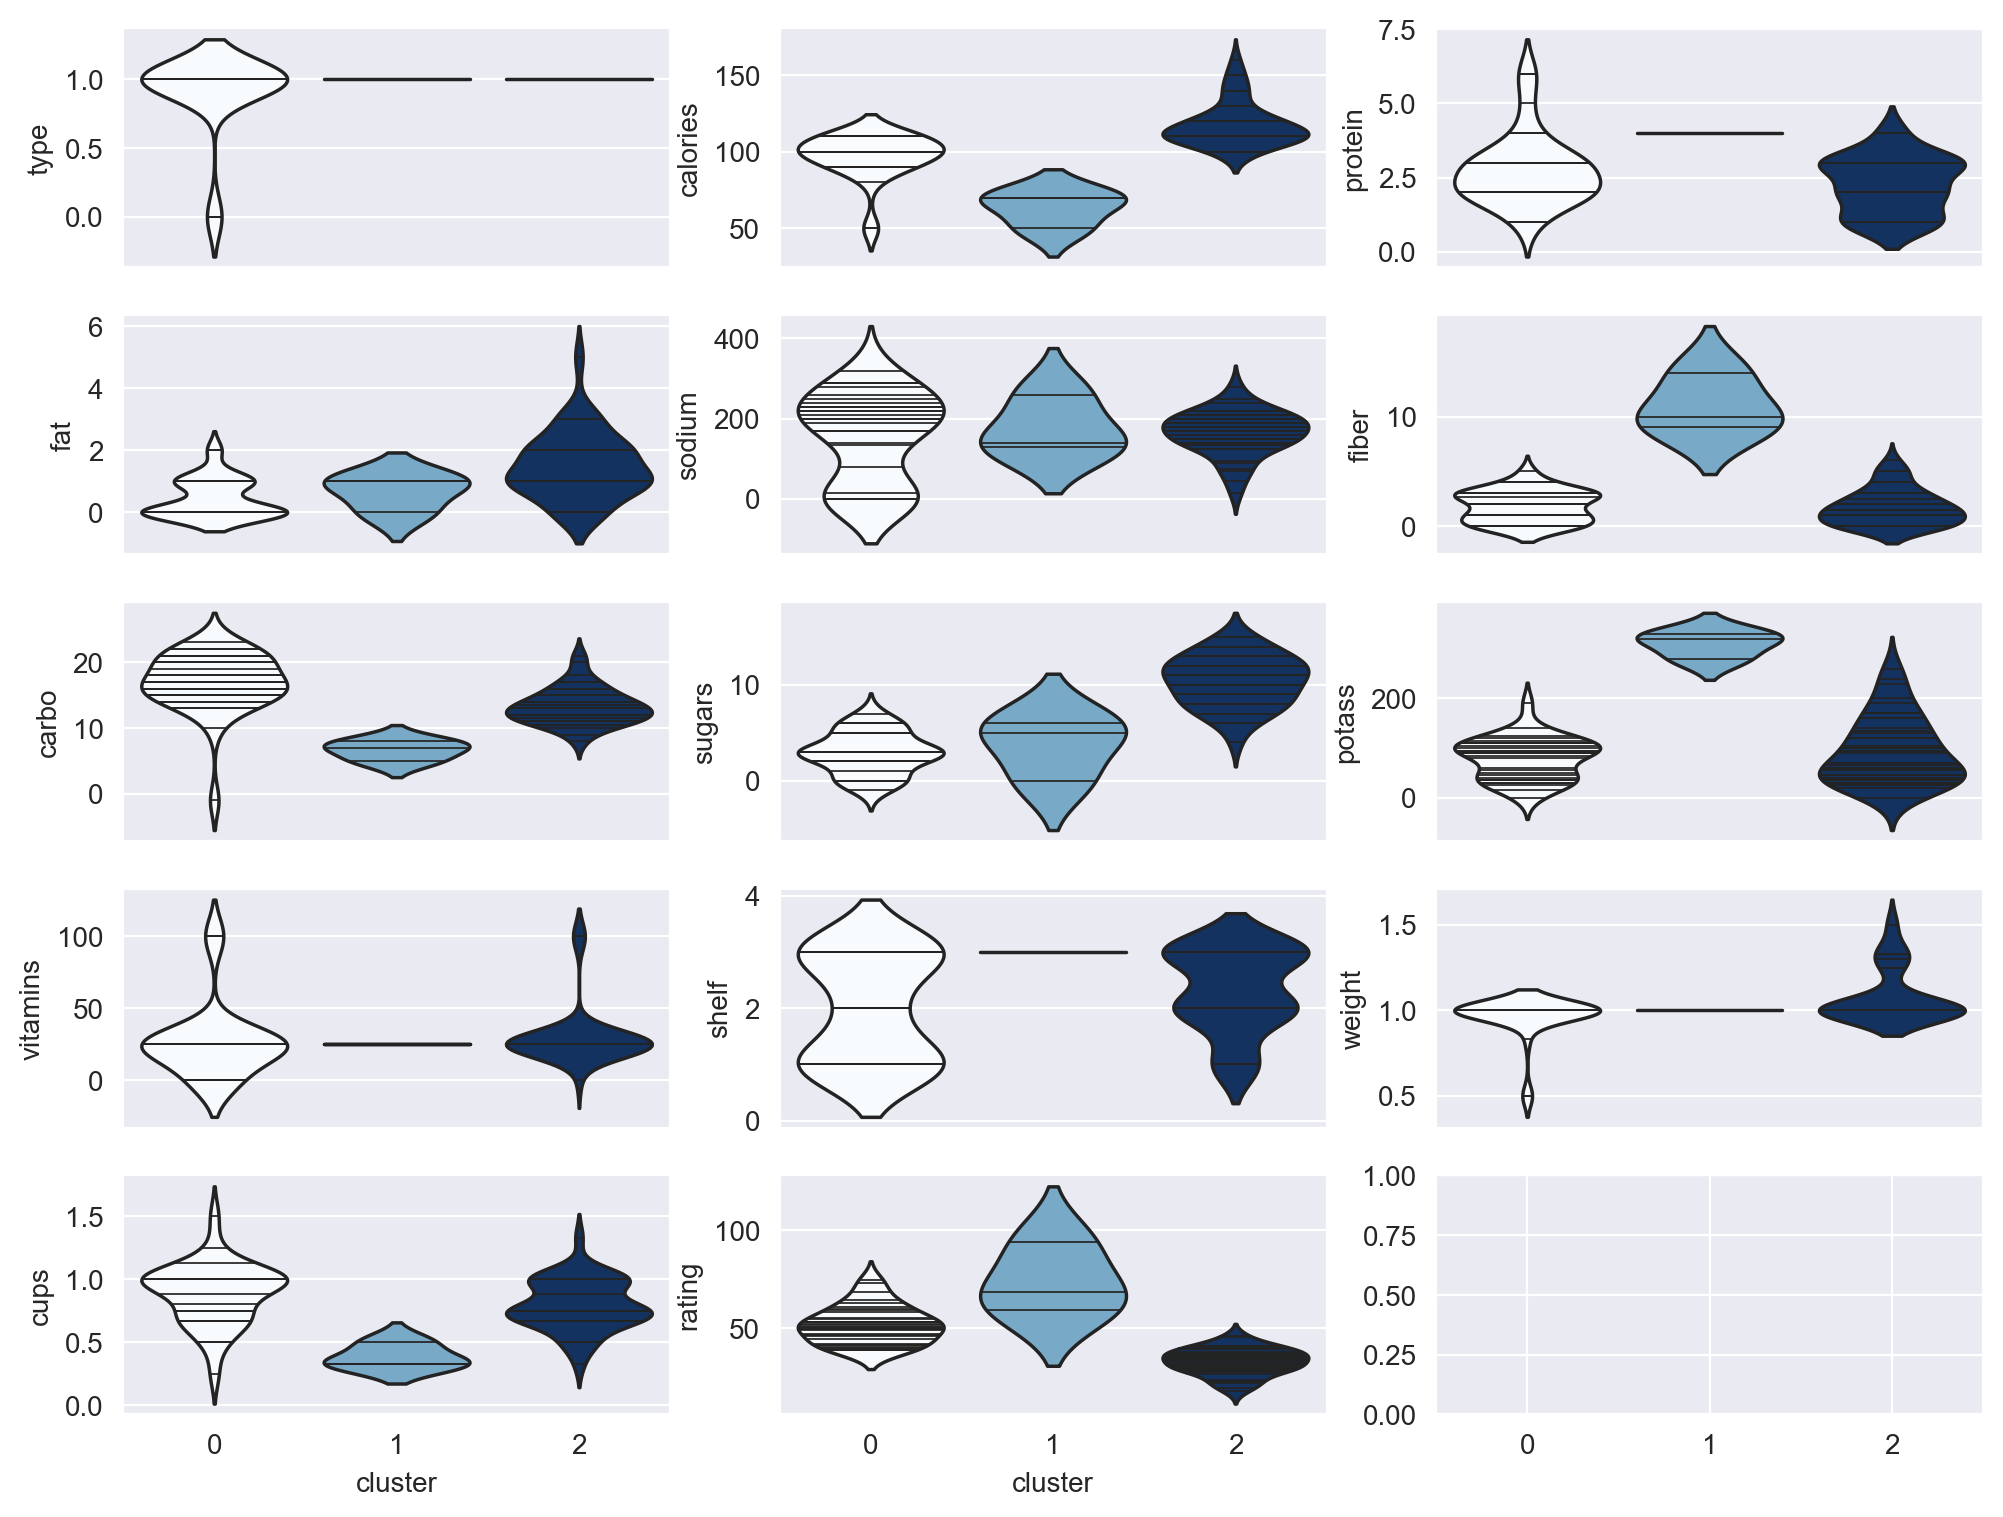

In [32]:
cols = [x for x in data.columns if x not in ['cluster']]
fig, axs = plt.subplots(nrows=math.ceil((len(cols))/3), ncols=3, sharex=True, figsize=(12, 9))
for ax, col in zip(axs.reshape(-1), cols):
    sns.violinplot(x='cluster', y=col, density_norm='area', inner='stick', data=data, ax=ax, palette='Blues', hue='cluster', legend=False)

On the graphs it is visible that:
* All elements of type 0 are in cluster 0
* Cereal of high level of potassium and fiber will most probably be in cluster 1
* Elements in cluster 3 have much more calories than those in cluster 1 and a little more than those in cluster 0.
* The cereals with weight lower than 1 are present in cluster 0, while those with mass above 1 - in 2
* In general elements in cluster 1 has best rating, while those in cluster 2 - the worst.
* If a cereal has high level of carbohydrates, it is most likely they will land in cluster 0
* Based on vitamins, the clusters are indistinguishable